# Normal Crossing RLCT Estimation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/normal_crossing.ipynb)

This notebook estimates the Local Learning Coefficient (LLC) of normal crossings using two algorithms: SGNHT (Stochastic Gradient Nose-Hoover Thermostat) and SGLD (Stochastic Gradient Langevin Dynamics). We recreate some key results from  [Lau et al. (2023)](https://arxiv.org/pdf/2308.12108.pdf), namely the ordinality check, trajectory plot, and the table of theoretical vs empirical learning coefficients. 

We use two different models in this notebook, one for testing LLC ordinality and one for doing visualisations and checking estimated LLCs against known values. For the ordinality check, we have a model $y = (w_1 - 1) *(w_1^2 + w_2^2)^2$ which we use to predict gaussian noise, so the best loss is reached when $w_1 = 1$ or $w_1 = w_2 = 0 $, the latter being more degenerate. The second model used for the comparison vs theory is a polynomial model characterized by $w_1^a * w_2^b$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned. The data is again gaussian noise, so the model achieves its lowest loss when $w_1=0$ or $w_2 =0$.

For a not-yet-finished version of the MNIST plot from this paper, see the MNIST notebook.

In [1]:
%pip install pyro-ppl seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# if you want to use your TPU (note that torch_xla is not by default installed, install using `pip install devinterp[tpu]`)
# import os
# os.environ["USE_TPU_BACKEND"] = "1"
# import torch_xla.core.xla_model as xm
# DEVICE = xm.xla_device()

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
from pyro.infer import MCMC, NUTS
from torch.utils.data import DataLoader, TensorDataset

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.llc import LLCEstimator, OnlineLLCEstimator, SamplerCallback
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, sample
from devinterp.utils import get_init_loss_multi_batch, plot_trace

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("whitegrid")

# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]

/home/svwin/devinterp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from devinterp.utils import evaluate_mse

# constants
SIGMA = 0.25
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
EVALUATE = evaluate_mse

In [5]:
# some necessary functions
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([0.0, 0.0], dtype=torch.float32, requires_grad=True).to(DEVICE)
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x * multiplied
        return x


class LinePlusDotModel(nn.Module):
    def __init__(self):
        super(LinePlusDotModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([0.0, 0.0], dtype=torch.float32, requires_grad=True).to(DEVICE)
        )

    def forward(self, x):
        return (
            x
            * (self.weights[0] - 1)
            * ((self.weights[0] ** 2 + self.weights[1] ** 2) ** 2)
        )


def generate_dataset_for_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    x = torch.normal(0, 2, size=(NUM_TRAIN_SAMPLES,))
    y = SIGMA * torch.normal(0, 1, size=(NUM_TRAIN_SAMPLES,))
    train_data = TensorDataset(x, y)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    return train_loader, train_data, x, y

# Benchmarking

First, let's estimate some RLCTs of a simple degenerate line and point, where the point is more degenerate than the line. We first estimate the RLCTs at the point, and then at the line. This is a reproduction of Figure 1 from [Lau et al. (2023)](https://arxiv.org/pdf/2308.12108.pdf).

In [6]:
from devinterp.utils import get_init_loss_multi_batch, default_nbeta

train_loader, train_data, x, y = generate_dataset_for_seed(0)
model = LinePlusDotModel().to(DEVICE)
lr = 0.0001
num_chains = 5
num_draws = 5000
nbeta = default_nbeta(train_loader)
sgld_llcs = []
sgnht_llcs = []
sample_points = [[0.0, 0.0], [1.0, 0.3]]
actual_rlcts = [0.25, 0.5]
for sample_point in sample_points:
    model.weights = nn.Parameter(
        torch.tensor(sample_point, dtype=torch.float32, requires_grad=True)
    )
    init_loss = get_init_loss_multi_batch(
        train_loader, num_chains, model, EVALUATE, DEVICE
    )
    sgnht_llc = LLCEstimator(
        num_chains=num_chains, num_draws=num_draws, nbeta=nbeta, init_loss=init_loss
    )
    sgld_llc = LLCEstimator(
        num_chains=num_chains, num_draws=num_draws, nbeta=nbeta, init_loss=init_loss
    )
    sample(
        model,
        train_loader,
        evaluate=EVALUATE,
        optimizer_kwargs=dict(lr=lr, bounding_box_size=0.5, nbeta=nbeta),
        sampling_method=SGNHT,
        num_chains=num_chains,
        num_draws=num_draws,
        device=DEVICE,
        callbacks=[sgnht_llc],
    )
    sample(
        model,
        train_loader,
        evaluate=EVALUATE,
        optimizer_kwargs=dict(lr=lr, localization=0.2, nbeta=nbeta),  # TODO FIX
        sampling_method=SGLD,
        num_chains=num_chains,
        num_draws=num_draws,
        device=DEVICE,
        callbacks=[sgld_llc],
    )
    sgld_llcs += [sgld_llc.get_results()]
    sgnht_llcs += [sgnht_llc.get_results()]

/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:216: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:220: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:239: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:53: UserWarning: You are taking more sample batches than there are dataloader bat

0.14887431263923645
[0.2005019336938858, 0.07028903812170029, 0.1147444099187851, 0.15498630702495575, 0.20384985208511353]
0.654302716255188
[0.56605064868927, 0.4899264872074127, 0.5089262127876282, 0.8386633396148682, 0.8679468631744385]
0.20462393760681152
[0.202658012509346, 0.205875962972641, 0.18717604875564575, 0.22053281962871552, 0.20687688887119293]
0.8179630041122437
[1.257343053817749, 0.9880695939064026, 0.8615443706512451, 0.404544860124588, 0.5783130526542664]


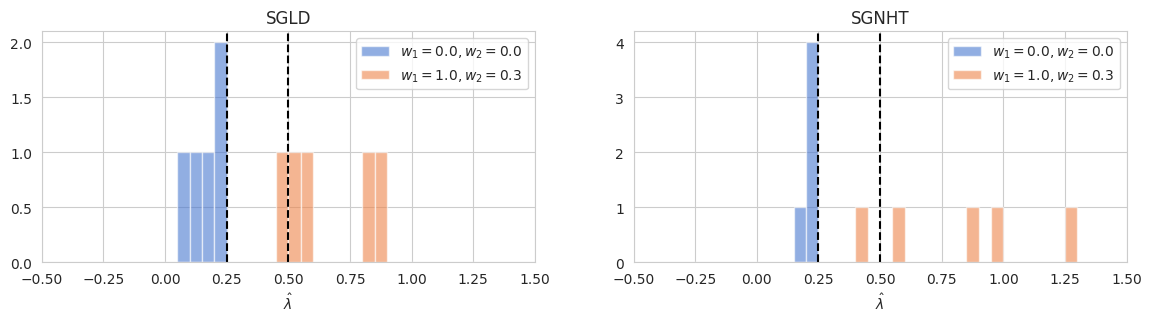

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
fig.patch.set_facecolor("white")
for i, (sampler_name, rlct_estimates) in enumerate(
    zip(["SGLD", "SGNHT"], [sgld_llcs, sgnht_llcs])
):
    axes[i].set_xlim([-0.5, 1.5])
    axes[i].set_title(sampler_name)
    axes[i].set_xlabel(r"$\hat\lambda$")
    for j, (rlct_estimates, sample_point) in enumerate(
        zip(rlct_estimates, sample_points)
    ):
        print(rlct_estimates["llc/mean"])
        print([rlct_estimates[f"llc-chain/{k}"] for k in range(num_chains)])
        axes[i].axvline(actual_rlcts[j], color="black", linestyle="--")
        axes[i].hist(
            [rlct_estimates[f"llc-chain/{i}"] for i in range(num_chains)],
            alpha=0.6,
            bins=40,
            range=(-0.5, 1.5),
            label=rf"$w_1={sample_point[0]:.1f}, w_2={sample_point[1]:.1f}$",
            color=SECONDARY if j else PRIMARY,
        )
    axes[i].legend()
plt.show()

# Trajectory Plots

Let's see how well our different sampling methods explore the local loss landscape. We start out sampling at $w_1 = 0.5, w_2 = 0.01$, and plot the resulting trajectories after 10k steps.

In [8]:
# plotting
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i : i + 2], 16) / 255.0 for i in (0, 2, 4))


lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple(
    [x + (1 - x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.0]
)

colors = [SECONDARY, lighter_SECONDARY]
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

powers = torch.tensor([1, 3]).to(DEVICE)
model = PolyModel(powers).to(DEVICE)


def plot_trajectories(trajectories, names, device=DEVICE):
    fig, axes = plt.subplots(1, len(trajectories), figsize=(15, 5))
    w1_range = np.linspace(-2, 2, 21)
    w2_range = np.linspace(-2, 2, 21)
    w1_vals, w2_vals = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(w1_vals, dtype=float)

    for i in range(w1_vals.shape[0]):
        for j in range(w1_vals.shape[1]):
            w1 = w1_vals[i, j]
            w2 = w2_vals[i, j]
            model.weights = nn.Parameter(
                torch.tensor([w1, w2], dtype=torch.float32).to(device)
            )
            Z[i, j] = (
                model.to(device)(torch.tensor(1.0).to(device)).item() ** 2
            )  # MSE, so square this

    custom_levels = np.linspace(Z.min(), Z.max() * 0.04, n_bins)

    for i, trajectory in enumerate(trajectories):
        axes[i].contourf(
            w1_vals, w2_vals, Z, levels=custom_levels, cmap=contour_cmap, alpha=0.8
        )
        weights = trajectory["ws/trace"][0]
        draws_array = np.array(
            [
                d
                for d in weights
                if w1_range[0] <= d[0] <= w1_range[-1]
                and w2_range[0] <= d[1] <= w2_range[-1]
            ]
        )
        sns.scatterplot(
            x=draws_array[:, 0],
            y=draws_array[:, 1],
            marker="x",
            ax=axes[i],
            s=10,
            color=PRIMARY,
        )
        axes[i].axhline(0, linestyle="--", color="gray")
        axes[i].axvline(0, linestyle="--", color="gray")
        axes[i].set_xlabel(r"$w_{1}$")
        axes[i].set_ylabel(r"$w_{2}$")
        axes[i].set_title(names[i])
        axes[i].grid(False)
    plt.show()

In [9]:
train_loader, train_data, x, y = generate_dataset_for_seed(0)

In [10]:
class WeightCallback(SamplerCallback):
    def __init__(self, num_chains: int, num_draws: int, model, device="cpu"):
        self.num_chains = num_chains
        self.num_draws = num_draws
        self.ws = np.zeros(
            (num_chains, num_draws, len(model.weights)), dtype=np.float32
        )
        self.device = device

    def update(self, chain: int, draw: int, model):
        self.ws[chain, draw] = model.weights.cpu().detach()

    def get_results(self):
        return {
            "ws/trace": self.ws,
        }

    def __call__(self, chain: int, draw: int, model, **kwargs):
        self.update(chain, draw, model)

In [11]:
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([0.5, 0.01], dtype=torch.float32, requires_grad=True).to(DEVICE)
)
lr = 0.0005
sgld_weights = WeightCallback(num_chains=1, num_draws=10_000, model=model)
sgnht_weights = WeightCallback(num_chains=1, num_draws=10_000, model=model)
trace_sgnht = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=lr,
        bounding_box_size=2.0,
        diffusion_factor=0.01,
        nbeta=default_nbeta(train_loader),
    ),
    sampling_method=SGNHT,
    num_chains=1,
    num_draws=10_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=True,
    device=DEVICE,
    callbacks=[sgnht_weights],
)
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([0.5, 0.01], dtype=torch.float32, requires_grad=True).to(DEVICE)
)
trace_sgld = sample(
    model,
    train_loader,
    evaluate=EVALUATE,
    optimizer_kwargs=dict(
        lr=lr,
        bounding_box_size=2.0,
        nbeta=default_nbeta(train_loader),
    ),
    sampling_method=SGLD,
    num_chains=1,
    num_draws=10_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=True,
    device=DEVICE,
    callbacks=[sgld_weights],
)
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([0.5, 0.01], dtype=torch.float32, requires_grad=True).to(DEVICE)
)
model = model.to("cpu")
model.powers = powers.to("cpu")
w_prior = dist.Normal(model.weights, torch.ones_like(model.weights)).to_event(1)


def pyro_model(x, y):
    w = pyro.sample("weights", w_prior)
    model.weights = nn.Parameter(w.to("cpu"))
    y_pred = model(x.to("cpu"))
    pyro.sample("obs", dist.Normal(y_pred, 0.5), obs=y.to("cpu"))


nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=20)
mcmc.run(x, y)

posterior_samples = mcmc.get_samples()
trace_mcmc = {"ws/trace": [posterior_samples["weights"].detach().cpu().numpy()]}

model = model.to(DEVICE)
model.powers = powers.to(DEVICE)

Chain 0:   0%|          | 0/10000 [00:00<?, ?it/s]

Sample: 100%|██████████| 520/520 [00:15, 34.49it/s, step size=1.56e+00, acc. prob=0.371] 


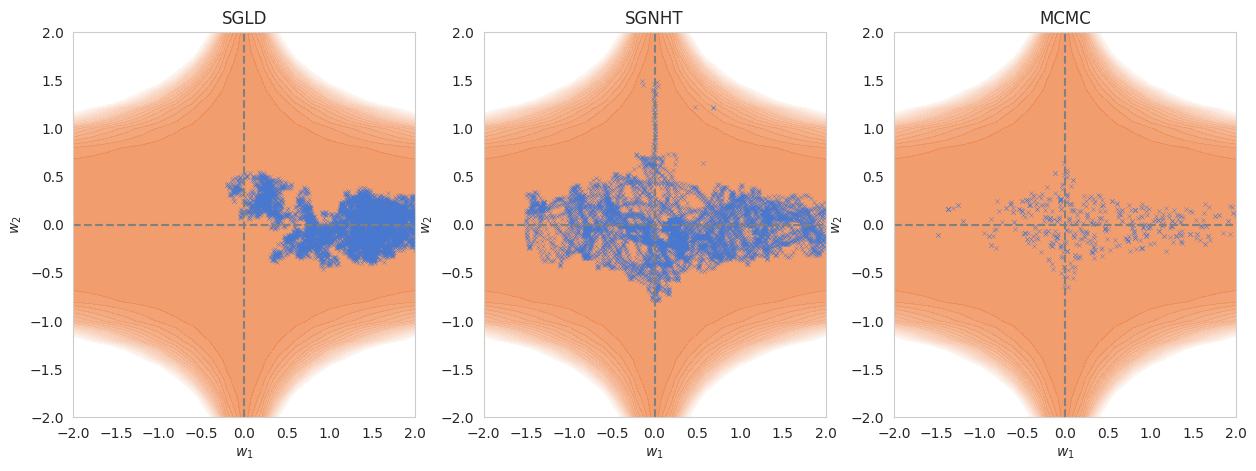

In [12]:
plot_trajectories(
    [sgld_weights.get_results(), sgnht_weights.get_results(), trace_mcmc],
    names=["SGLD", "SGNHT", "MCMC"],
)

# Benchmarking

Finally, let's check if we get the expected lambdahat values for a few different crossings. This is similar to Table 1 from [Lau et al. (2023)](https://arxiv.org/pdf/2308.12108.pdf).

In [13]:
train_loader, train_data, x, y = generate_dataset_for_seed(0)
lr = 0.0001
num_chains = 3
num_draws = 5000
powers_to_test = [
    torch.tensor([0, 1]).to(DEVICE),
    torch.tensor([0, 2]).to(DEVICE),
    torch.tensor([0, 3]).to(DEVICE),
    torch.tensor([1, 1]).to(DEVICE),
    torch.tensor([1, 2]).to(DEVICE),
    torch.tensor([1, 3]).to(DEVICE),
    torch.tensor([2, 2]).to(DEVICE),
    torch.tensor([2, 3]).to(DEVICE),
    torch.tensor([3, 3]).to(DEVICE),
]
rlct_estimates_sgld = {
    tuple(power.detach().cpu().tolist()): estimate_learning_coeff_with_summary(
        model=PolyModel(power),
        loader=train_loader,
        optimizer_kwargs=dict(
            lr=lr,
            bounding_box_size=1.0,
            nbeta=default_nbeta(train_loader),
        ),
        evaluate=EVALUATE,
        sampling_method=SGLD,
        num_chains=num_chains,
        num_draws=num_draws,
        device=DEVICE,
    )
    for power in powers_to_test
}
rlct_estimates_sgnht = {
    tuple(power.detach().cpu().tolist()): estimate_learning_coeff_with_summary(
        model=PolyModel(power),
        loader=train_loader,
        optimizer_kwargs=dict(
            lr=lr,
            bounding_box_size=1.0,
            diffusion_factor=0.01,
            nbeta=default_nbeta(train_loader),
        ),
        evaluate=EVALUATE,
        sampling_method=SGNHT,
        num_chains=num_chains,
        num_draws=num_draws,
        device=DEVICE,
    )
    for power in powers_to_test
}

/home/svwin/devinterp/src/devinterp/slt/sampler.py:50: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:216: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:220: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/svwin/devinterp/src/devinterp/backends/default/slt/sampler.py:239: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbac

Chain 2: 100%|██████████| 5000/5000 [00:02<00:00, 1790.13it/s]


In [14]:
for sampler_type, estimates in zip(
    ("sgld", "sgnht"), (rlct_estimates_sgld, rlct_estimates_sgnht)
):
    df_data = {
        "powers": [k for k in estimates.keys()],
        "LLC_Summary": estimates.values(),
    }
    df = pd.DataFrame(df_data)
    df["llc_mean"] = df["LLC_Summary"].apply(lambda x: x["llc/mean"])
    df["llc_std"] = df["LLC_Summary"].apply(lambda x: x["llc/std"])
    df = df.drop("LLC_Summary", axis=1)
    print(sampler_type)
    print(df.to_string(index=False))

sgld
powers  llc_mean  llc_std
(0, 1)  0.499807 0.033900
(0, 2)  0.301098 0.111747
(0, 3)  0.108836 0.006892
(1, 1)  0.350617 0.041256
(1, 2)  0.156247 0.136191
(1, 3)  0.048869 0.017304
(2, 2)  0.085732 0.053104
(2, 3)  0.084958 0.125995
(3, 3)  0.099944 0.130149
sgnht
powers  llc_mean  llc_std
(0, 1)  0.492101 0.075376
(0, 2)  0.231741 0.015389
(0, 3)  0.173720 0.032608
(1, 1)  0.378363 0.042097
(1, 2)  0.232073 0.012143
(1, 3)  0.172249 0.031408
(2, 2)  0.178082 0.017687
(2, 3)  0.114668 0.013921
(3, 3)  0.081164 0.018655
